In [1]:
# Import necessary libraries
import os
from PIL import Image
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Ensure the device is correctly set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model with ignoring unexpected keys
model = models.segmentation.deeplabv3_resnet50(weights=None, num_classes=2)
checkpoint = torch.load('deeplabv3_rock_detection.pth')
model.load_state_dict(checkpoint, strict=False)
model = model.to(device)
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [3]:
# Define a function for inference and visualization
def predict_and_visualize(image_path, model, transform, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    input_image = transform(image).unsqueeze(0).to(device)
    
    # Perform inference
    with torch.no_grad():
        output = model(input_image)['out']
    prediction = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
    
    # Resize prediction to match original image size
    prediction_resized = np.array(Image.fromarray(prediction.astype(np.uint8)).resize(image.size, resample=Image.NEAREST))
    
    # Overlay the mask on the original image
    mask_overlay = Image.fromarray(prediction_resized).convert("RGBA")
    mask_overlay = Image.blend(image.convert("RGBA"), mask_overlay, alpha=0.5)
    
    # Visualize the input image, prediction, and overlay
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    
    # Original image
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    # Predicted mask
    ax[1].imshow(prediction_resized, cmap='gray')
    ax[1].set_title('Predicted Mask')
    ax[1].axis('off')
    
    # Overlay of the mask on the image
    ax[2].imshow(mask_overlay)
    ax[2].set_title('Overlay')
    ax[2].axis('off')
    
    plt.show()

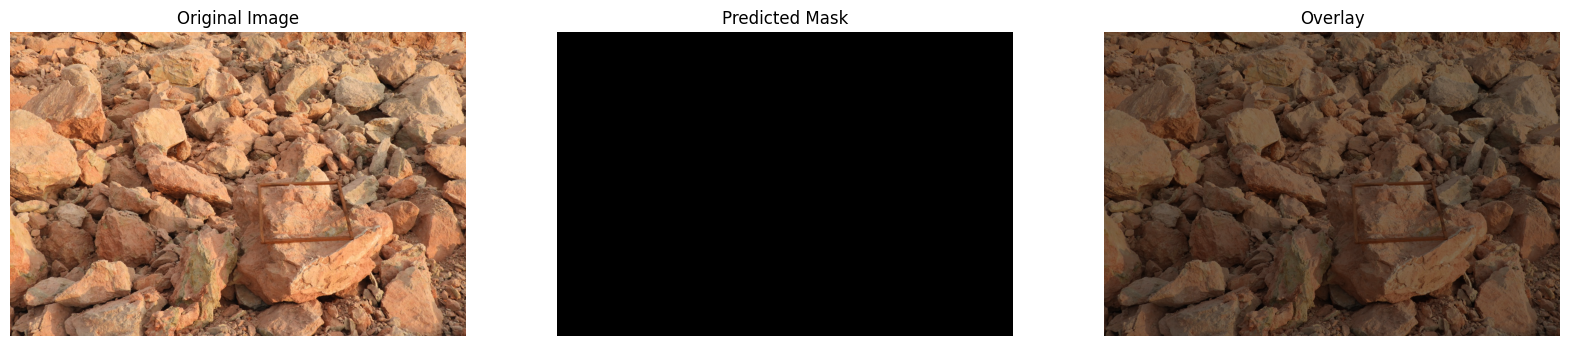

In [4]:
# Path to the validation image
image_path = 'data/val/images/4.jpeg'

# Use the same transformation as used during training
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Perform inference and visualize the result
predict_and_visualize(image_path, model, transform, device)